/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


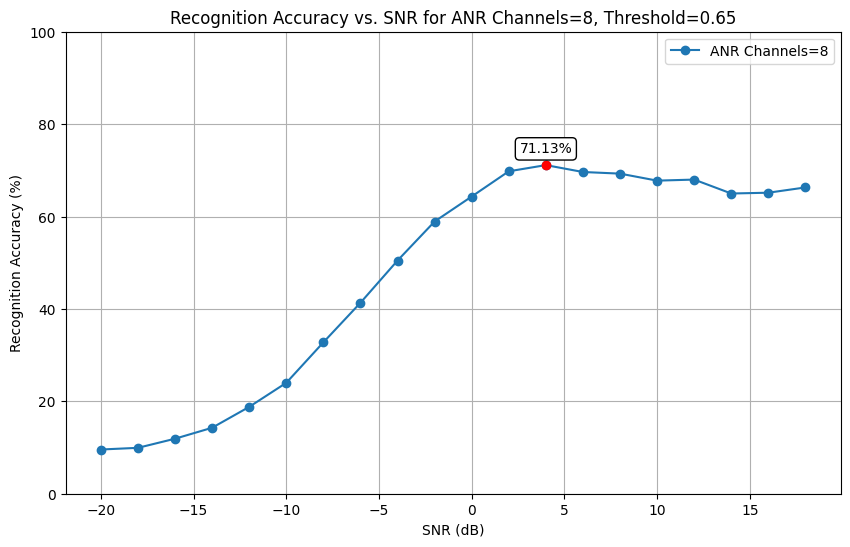

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


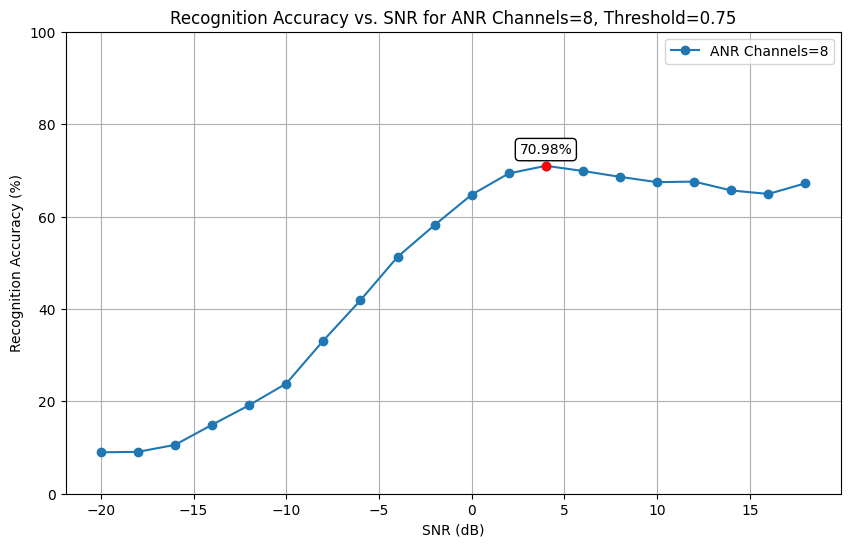

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


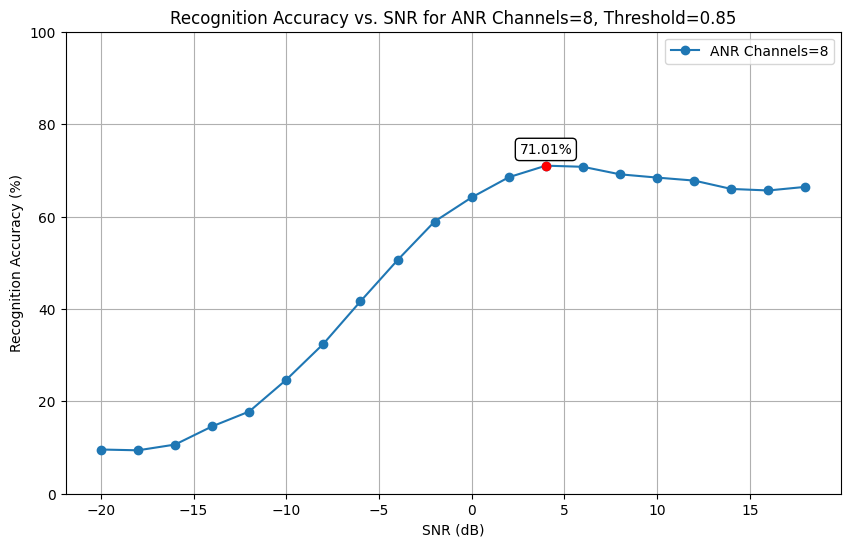

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


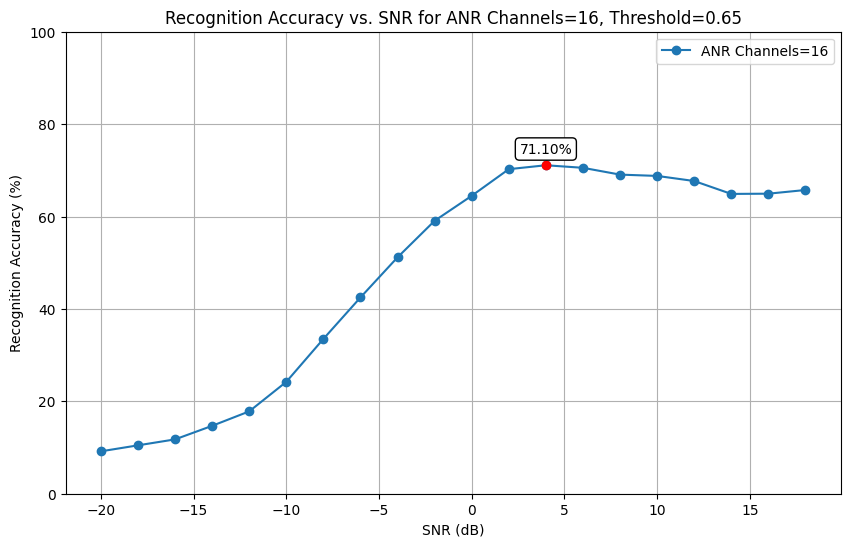

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


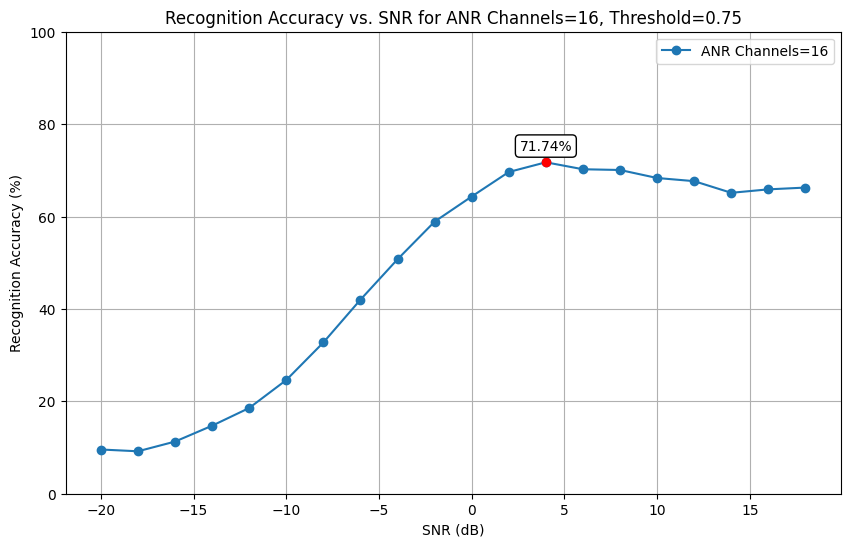

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


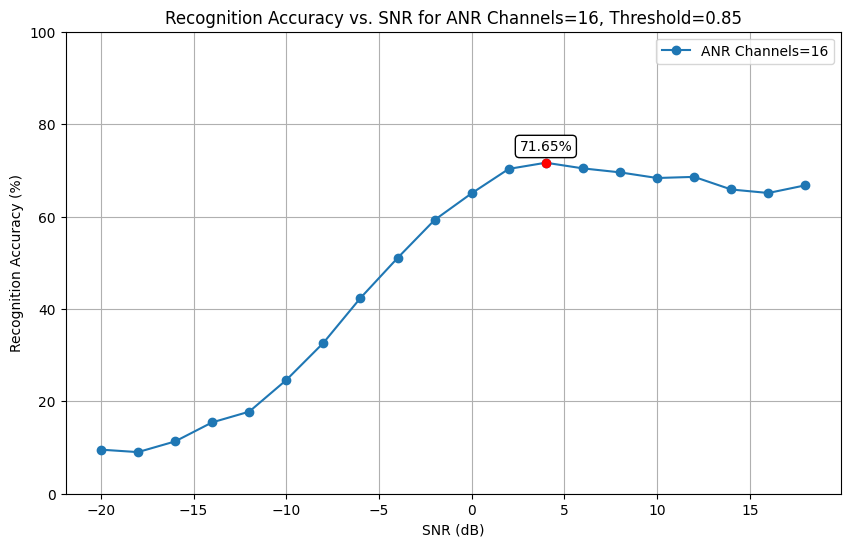

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


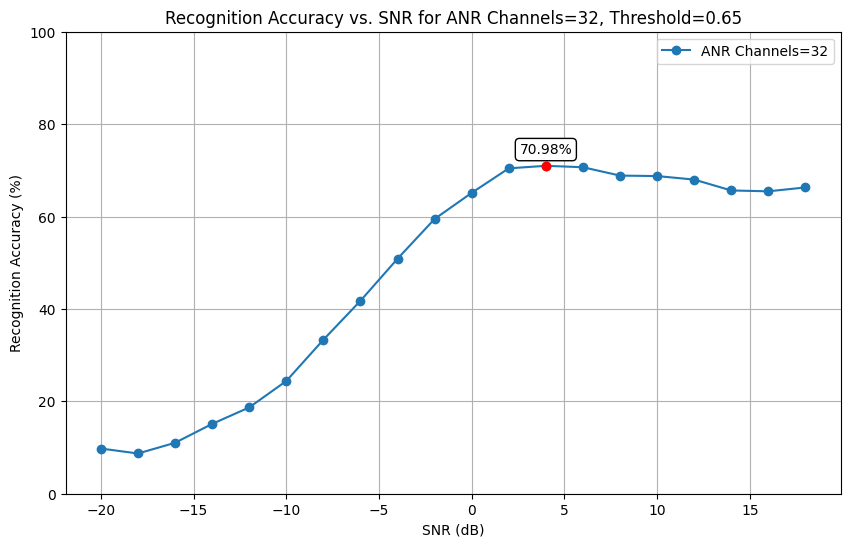

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


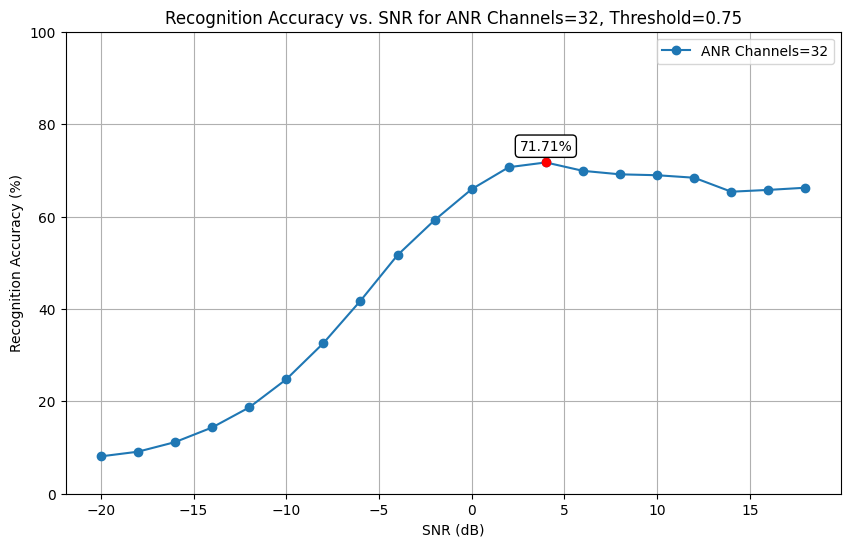

/home/eng/python/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:600: UserWarning: nperseg = 256 is greater than input length  = 128, using nperseg = 128
  freqs, _, Pxy = _spectral_helper(x, y, fs, window, nperseg, noverlap,


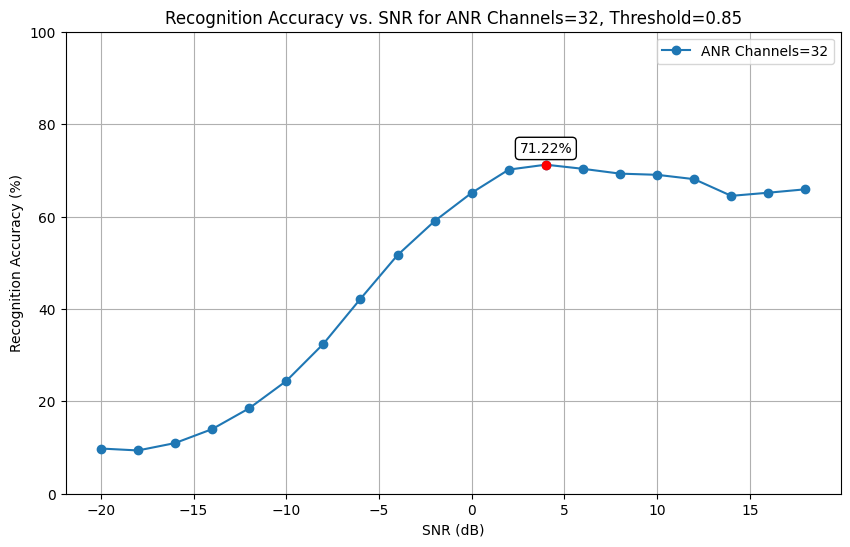

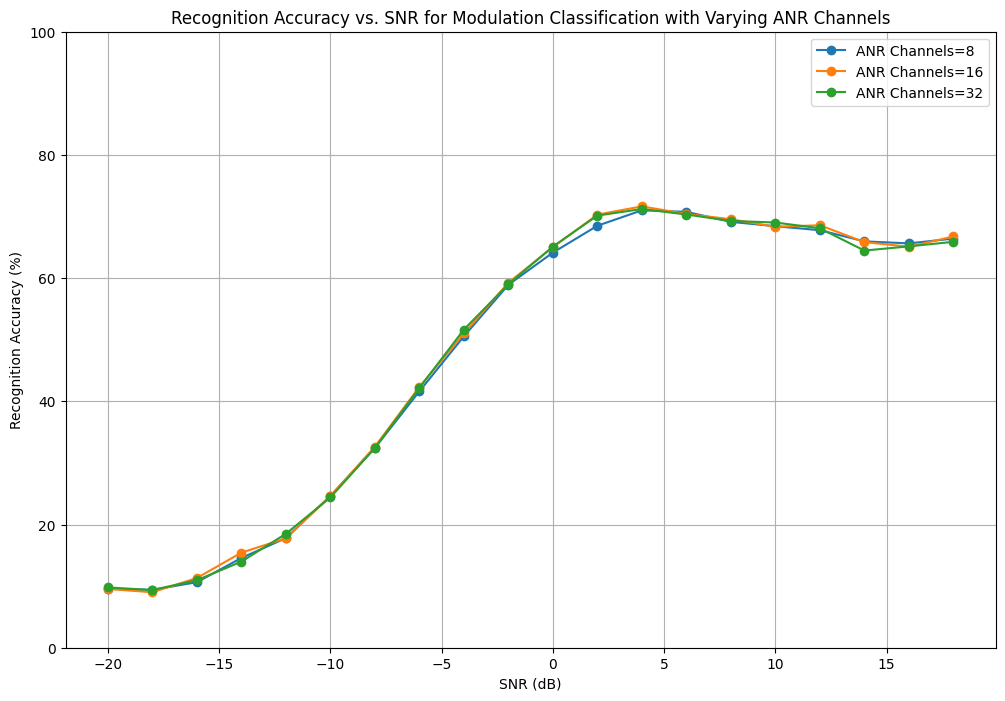

In [1]:
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
from ml_wireless_classification.base.SignalUtils import clean_training_data, ensure_2d
from ml_wireless_classification.base.ANR import AdaptiveNoiseReduction
from ml_wireless_classification.base.SignalUtils import (
    compute_instantaneous_features, compute_modulation_index, compute_spectral_asymmetry,
    instantaneous_frequency_deviation, spectral_entropy, envelope_mean_variance,
    spectral_flatness, spectral_peaks_bandwidth, zero_crossing_rate, compute_fft_features,
    autocorrelation, is_digital_signal, compute_kurtosis, compute_skewness,
    compute_spectral_energy_concentration, compute_instantaneous_frequency_jitter,
    compute_spectral_kurtosis, compute_higher_order_cumulants, compute_crest_factor,
    compute_spectral_entropy, compute_energy_spread, compute_autocorrelation_decay,
    compute_rms_of_instantaneous_frequency, compute_entropy_of_instantaneous_frequency,
    compute_envelope_variance, compute_papr
)
# ANR channel configurations to test
channel_configs = [8, 16, 32]

# Global dictionary to store feature names and values
feature_dict = {}

def add_feature(name, func, *args):
    """Try to add a feature by checking the shape and ensuring it’s a scalar."""
    try:
        value = func(*args)
        if np.isscalar(value) or (isinstance(value, np.ndarray) and value.size == 1):
            feature_dict[name] = value.item() if isinstance(value, np.ndarray) else value
        else:
            print(f"Warning: Feature '{name}' has incorrect shape and was not added.")
    except Exception as e:
        print(f"Error computing feature '{name}': {e}")

# Function to extract features for each ANR configuration
def extract_features_with_anr(data, num_channels, threshold = 0.8):
    features = []
    labels = []
    anr = AdaptiveNoiseReduction(num_channels=num_channels, threshold=threshold, method="gaussian")

    for key, signals in data.items():
        mod_type, snr = key
        for signal in signals:
            real_part, imag_part = signal[0], signal[1]

            # Apply ANR to IQ data and replace real_part and imag_part with denoised versions
            real_denoised = anr.forward(torch.tensor(real_part).float())
            imag_denoised = anr.forward(torch.tensor(imag_part).float())

            complex_signal = real_denoised + 1j * imag_denoised

            # Reset feature dictionary for each signal
            global feature_dict
            feature_dict = {}

            # Feature extraction (add more features as needed)
            add_feature("Inst. Freq. Dev", instantaneous_frequency_deviation, complex_signal)
            add_feature("Spectral Entropy", spectral_entropy, real_denoised)
            add_feature("Envelope Mean", lambda x: envelope_mean_variance(x)[0], real_denoised)
            add_feature("Envelope Variance", lambda x: envelope_mean_variance(x)[1], real_denoised)
            add_feature("Spectral Flatness", spectral_flatness, real_denoised)
            feature_dict["SNR"] = snr  # Include SNR as part of the features

            # Append feature values and label
            features.append(list(feature_dict.values()))
            labels.append(mod_type)

    return np.array(features), labels

# Load the dataset
with open("../RML2016.10a_dict.pkl", "rb") as f:
    data = pickle.load(f, encoding="latin1")

# Store accuracy results for each channel configuration
results = {}
thresholds = np.arange(0.65,0.95,0.1).tolist()
# Loop through each channel configuration
for num_channels in channel_configs:
    for threshold in thresholds:
        # Extract features with the current ANR configuration
        features, labels = extract_features_with_anr(data, num_channels, threshold)
        
        # Encode labels for classification
        label_encoder = LabelEncoder()
        encoded_labels = label_encoder.fit_transform(labels)
        
        # Split dataset into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(features, encoded_labels, test_size=0.3, random_state=42)
        
        # Clean training and test data
        X_train, y_train = clean_training_data(X_train, y_train)
        X_test, y_test = clean_training_data(X_test, y_test)
        
        # Ensure both X_train and X_test are 2D arrays
        X_train = ensure_2d(X_train, "X_train")
        X_test = ensure_2d(X_test, "X_test")
        
        # Train a classifier
        clf = RandomForestClassifier(n_estimators=50, random_state=42)
        clf.fit(X_train, y_train)
        
        # Evaluate accuracy for each SNR level
        unique_snrs = sorted(set(X_test[:, -1]))  # Get unique SNR levels from test set
        accuracy_per_snr = []

        for snr in unique_snrs:
            # Select samples with the current SNR
            snr_indices = np.where(X_test[:, -1] == snr)
            X_snr = X_test[snr_indices]
            y_snr = y_test[snr_indices]

            # Predict and calculate accuracy
            y_pred = clf.predict(X_snr)
            accuracy = accuracy_score(y_snr, y_pred)
            accuracy_per_snr.append(accuracy * 100)  # Convert to percentage

        results[num_channels] = (unique_snrs, accuracy_per_snr)

        # Plot the results for this configuration
        plt.figure(figsize=(10, 6))
        plt.plot(unique_snrs, accuracy_per_snr, marker='o', label=f'ANR Channels={num_channels}')
        plt.xlabel("SNR (dB)")
        plt.ylabel("Recognition Accuracy (%)")
        plt.title(f"Recognition Accuracy vs. SNR for ANR Channels={num_channels}, Threshold={threshold}")

        # Add text box at peak accuracy
        peak_accuracy = max(accuracy_per_snr)
        peak_snr = unique_snrs[accuracy_per_snr.index(peak_accuracy)]
        plt.plot(peak_snr, peak_accuracy, 'ro')  # Red dot at the peak
        plt.text(peak_snr, peak_accuracy + 2, f"{peak_accuracy:.2f}%", ha='center', 
                va='bottom', fontsize=10, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))
        
        plt.legend()
        plt.grid(True)
        plt.ylim(0, 100)
        plt.show()

# Plot Recognition Accuracy vs. SNR for all ANR channel configurations together
plt.figure(figsize=(12, 8))
for num_channels, (snrs, accuracies) in results.items():
    plt.plot(snrs, accuracies, marker='o', label=f'ANR Channels={num_channels}')
    
plt.xlabel("SNR (dB)")
plt.ylabel("Recognition Accuracy (%)")
plt.title("Recognition Accuracy vs. SNR for Modulation Classification with Varying ANR Channels")
plt.legend()
plt.grid(True)
plt.ylim(0, 100)
plt.show()
